<a href="https://colab.research.google.com/github/akashrajeshnair/nutrivision-training/blob/main/fruitmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install kaggle

ERROR: Operation cancelled by user


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download kritikseth/fruit-and-vegetable-image-recognition

Dataset URL: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition
License(s): CC0-1.0
100% 1.98G/1.98G [01:32<00:00, 23.9MB/s]
100% 1.98G/1.98G [01:32<00:00, 23.0MB/s]


In [ ]:
!unzip fruit-and-vegetable-image-recognition.zip

Archive:  fruit-and-vegetable-image-recognition.zip
  inflating: test/apple/Image_1.jpg  
  inflating: test/apple/Image_10.jpg  
  inflating: test/apple/Image_2.jpg  
  inflating: test/apple/Image_3.jpg  
  inflating: test/apple/Image_4.jpg  
  inflating: test/apple/Image_5.jpg  
  inflating: test/apple/Image_6.JPG  
  inflating: test/apple/Image_7.jpg  
  inflating: test/apple/Image_8.jpg  
  inflating: test/apple/Image_9.jpg  
  inflating: test/banana/Image_1.jpg  
  inflating: test/banana/Image_10.jpg  
  inflating: test/banana/Image_2.jpg  
  inflating: test/banana/Image_3.jpg  
  inflating: test/banana/Image_4.jpg  
  inflating: test/banana/Image_5.jpg  
  inflating: test/banana/Image_6.jpg  
  inflating: test/banana/Image_8.jpg  
  inflating: test/banana/Image_9.jpg  
  inflating: test/beetroot/Image_1.jpg  
  inflating: test/beetroot/Image_10.jpg  
  inflating: test/beetroot/Image_2.jpg  
  inflating: test/beetroot/Image_3.jpg  
  inflating: test/beetroot/Image_4.jpg  
  inflati

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
train_dir = '/content/train'
validation_dir = '/content/validation'
test_dir = '/content/test'

In [ ]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(f'number of classes in {folder_name} folder : {len(classes)}')

num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 35
number of classes in validation folder : 35
number of classes in test folder : 35


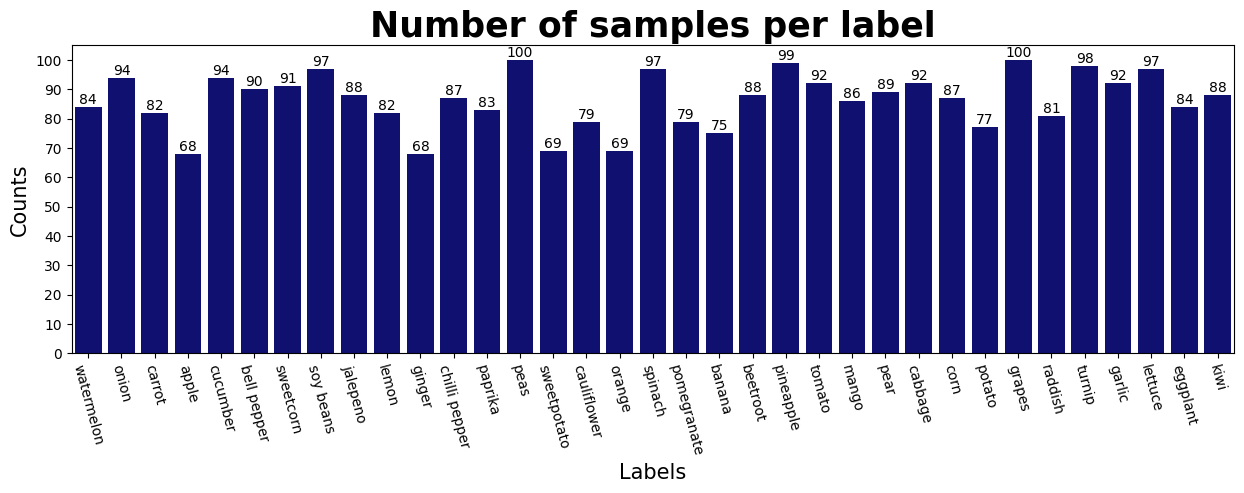

In [ ]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

In [ ]:
def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

print(f'Number of samples in train : {len(train_df)}')
print(f'Number of samples in validation : {len(validation_df)}')
print(f'Number of samples test : {len(test_df)}')

Number of samples in train : 3026
Number of samples in validation : 341
Number of samples test : 349


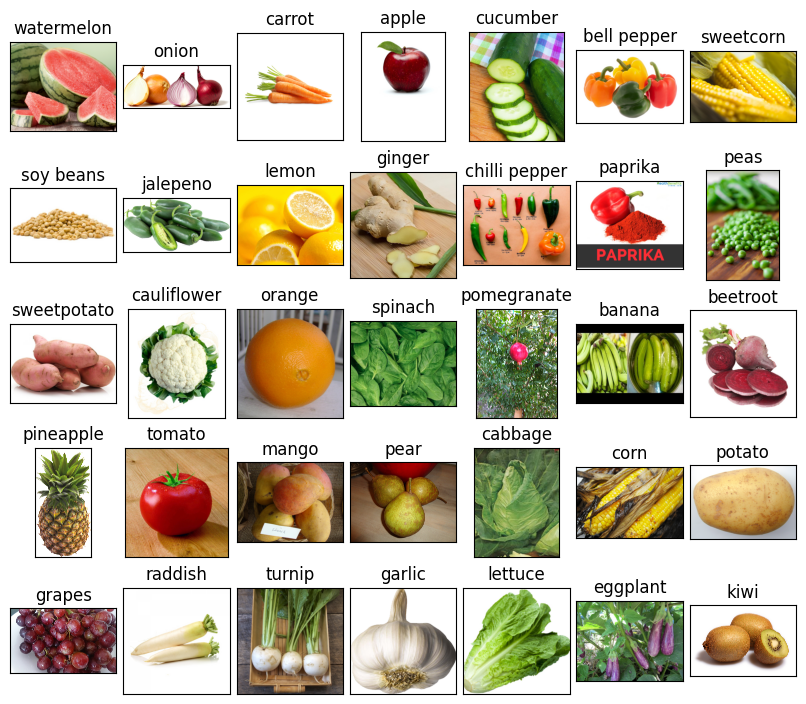

In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=5, ncols=7, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
batch_size = 32
img_size = (299, 299)

train_dataset = image_dataset_from_directory(
    '/content/train',
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

validation_dataset = image_dataset_from_directory(
    '/content/validation',
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size
)

test_dataset = image_dataset_from_directory(
    '/content/test',
    labels="inferred",
    label_mode="categorical",
    shuffle=False,
    batch_size=batch_size,
    image_size=img_size
)

class_names = train_dataset.class_names
print(class_names)

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Apply data augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Normalize datasets
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))


Found 3026 files belonging to 35 classes.
Found 341 files belonging to 35 classes.
Found 349 files belonging to 35 classes.
['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [ ]:
model = InceptionV3(weights='imagenet', include_top = False, input_shape=(299, 299, 3))

model.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(35, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 149, 149, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 149, 149, 32)         96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 149, 149, 32)         0         ['batch_normalization_94

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='mymodel.h5', save_best_only=True)
]

trained = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
95/95 [==============================] - 116s 1s/step - loss: 0.2465 - accuracy: 0.9147 - val_loss: 0.2069 - val_accuracy: 0.9355
Epoch 2/30
95/95 [==============================] - 112s 1s/step - loss: 0.2514 - accuracy: 0.9111 - val_loss: 0.2203 - val_accuracy: 0.9208
Epoch 3/30
95/95 [==============================] - 114s 1s/step - loss: 0.2609 - accuracy: 0.9114 - val_loss: 0.2115 - val_accuracy: 0.9208
Epoch 4/30
95/95 [==============================] - 112s 1s/step - loss: 0.2324 - accuracy: 0.9131 - val_loss: 0.2405 - val_accuracy: 0.9208
Epoch 5/30
95/95 [==============================] - 112s 1s/step - loss: 0.2130 - accuracy: 0.9213 - val_loss: 0.2108 - val_accuracy: 0.9501
Epoch 6/30
95/95 [==============================] - 115s 1s/step - loss: 0.2084 - accuracy: 0.9207 - val_loss: 0.2374 - val_accuracy: 0.9238


In [ ]:
result_df = pd.DataFrame(trained.history)
result_df.tail()

,loss,accuracy,val_loss,val_accuracy
1,0.251442,0.911104,0.220263,0.920821
2,0.260921,0.911434,0.211541,0.920821
3,0.232397,0.913087,0.240547,0.920821
4,0.212961,0.921348,0.210755,0.950147
5,0.208421,0.920687,0.237401,0.923754


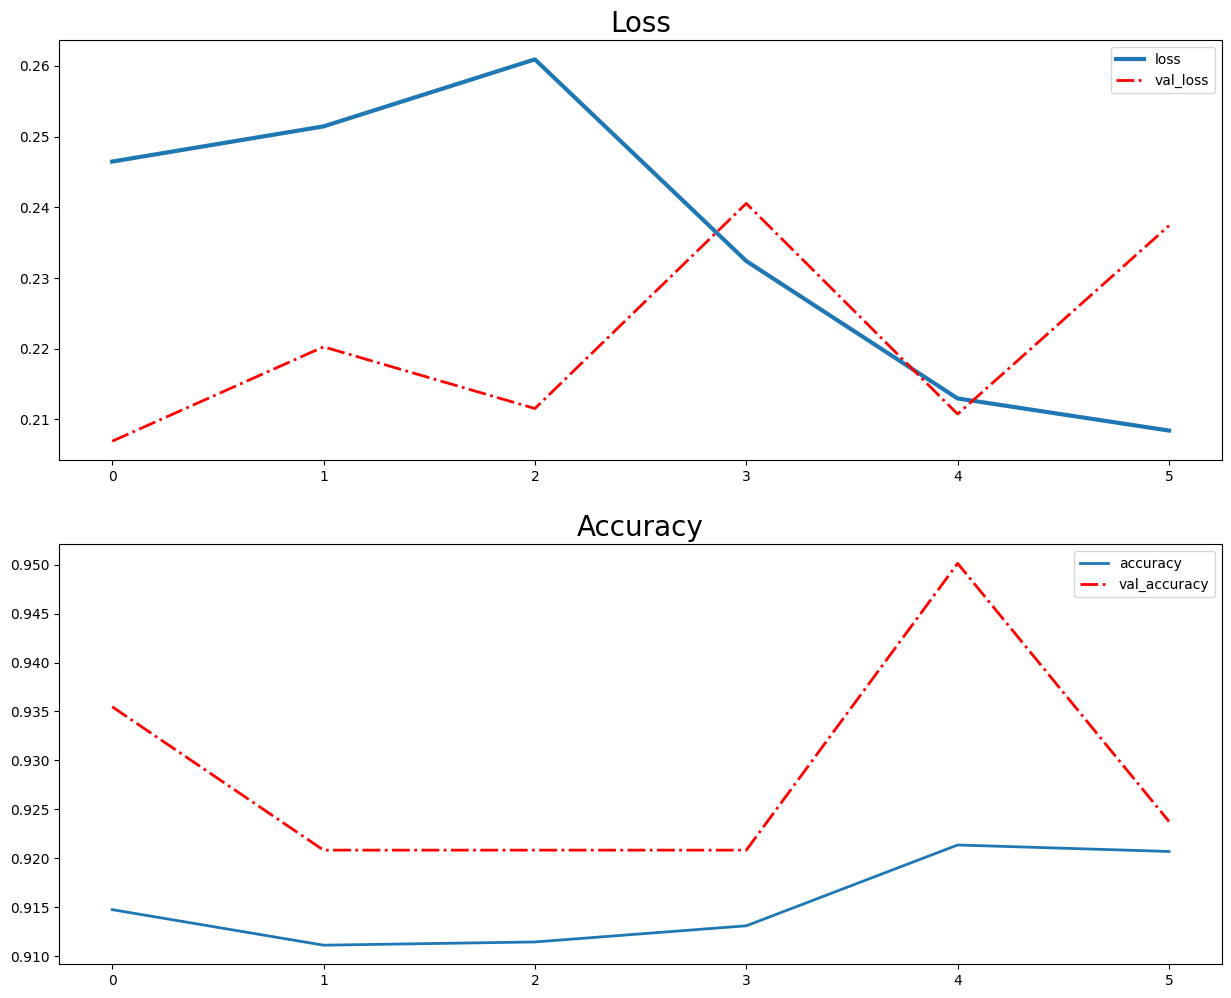

In [ ]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

plt.sharex=True


plt.show()



In [ ]:
best = tf.keras.models.load_model('/content/mymodel.h5')


test_loss, test_accuracy = best.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')


11/11 [==============================] - 16s 1s/step - loss: 0.2106 - accuracy: 0.9312
Test accuracy: 0.9312320947647095


In [ ]:
batch_size = 32
img_size = (299, 299)
class_names = ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']

# Function to load and preprocess image
def load_and_preprocess_image(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def predict_image(model, img_path, img_size, class_names):
    img_array = load_and_preprocess_image(img_path, img_size)
    predictions = model.predict(img_array)
    top_3_indices = np.argsort(predictions[0])[-3:][::-1]
    top_3_classes = [class_names[i] for i in top_3_indices]
    top_3_probs = [predictions[0][i] for i in top_3_indices]
    return top_3_classes, top_3_probs

# Example usage for prediction
img_path = '/content/orange.jpeg'  # Replace with your image path
top_3_classes, top_3_probs = predict_image(best, img_path, img_size, class_names)
print(f'Top 3 predicted classes: {top_3_classes}')
print(f'Top 3 prediction probabilities: {top_3_probs}')

1/1 [==============================] - 4s 4s/step
Top 3 predicted classes: ['orange', 'lemon', 'banana']
Top 3 prediction probabilities: [0.9197166, 0.07360863, 0.002084462]


1/1 [==============================] - 0s 48ms/step


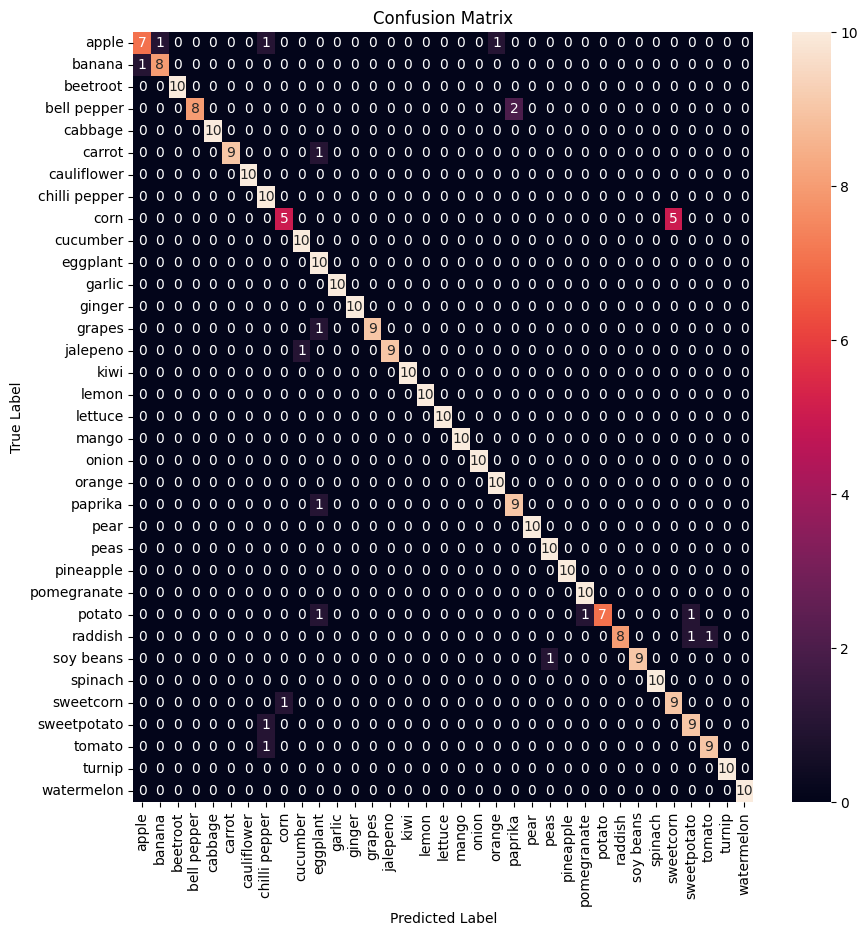

In [ ]:
def plot_confusion_matrix(model, test_dataset, class_names):
    y_true = []
    y_pred = []

    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(model.predict(images), axis=1))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(best, test_dataset, class_names)

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/mymodel.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

lite_model = converter.convert()

with open("lite_model.tflite", "wb") as f:
  f.write(lite_model)